In [1]:
import logging
logger = logging.getLogger('retrain_contract_uber_model')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.info('logging started')

2020-06-28 23:12:23,970 - retrain_contract_uber_model - INFO - logging started


In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [3]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [4]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [5]:

if not IN_COLAB:
  import analyser.hyperparams  
  _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
  work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)
  
  if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

  analyser.hyperparams.work_dir = work_dir
else:
  import analyser.hyperparams
  from google.colab import drive
  drive.mount('/content/drive')
  os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
  analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v1.22.0
USING WORKDIR: [/Users/artem/work/nemo/goil/nlp_tools/work]
 set ENV GPN_WORK_DIR to override
work_dir= /Users/artem/work/nemo/goil/work


/Users/artem/work/nemo/goil/nlp_tools/analyser/hyperparams.py:14: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


# Imports

In [6]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 
import os
import random
import math
import json
import warnings

from os import path

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, seq_labels_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


1.15.2


Using TensorFlow backend.


loading word cases stats model from: /Users/artem/work/nemo/goil/nlp_tools/analyser/vocab/word_cases_stats.pickle
HyperParameters.subsidiary_name_match_min_jaro_similarity 0.98


# Prepare trainset


In [7]:
umtm = UberModelTrainsetManager ( analyser.hyperparams.work_dir)

if not IN_COLAB:
  umtm.import_recent_contracts()
  umtm.calculate_samples_weights()
  umtm.validate_trainset()

2020-06-28 23:12:33,486 - retrain_contract_uber_model - INFO - TOTAL DATAPOINTS IN TRAINSET: 594
2020-06-28 23:12:33,486 - retrain_contract_uber_model - INFO - TOTAL DATAPOINTS IN TRAINSET: 594
I0628 23:12:33.486582 4570262976 retrain_contract_uber_model.py:262] TOTAL DATAPOINTS IN TRAINSET: 594
2020-06-28 23:12:33,598 - retrain_contract_uber_model - INFO - TOTAL DATAPOINTS IN TRAINSET: 594
2020-06-28 23:12:33,598 - retrain_contract_uber_model - INFO - TOTAL DATAPOINTS IN TRAINSET: 594
I0628 23:12:33.598501 4570262976 retrain_contract_uber_model.py:262] TOTAL DATAPOINTS IN TRAINSET: 594
2020-06-28 23:12:33,604 - retrain_contract_uber_model - INFO - latest export_date: [2020-06-26 00:05:14.688000]
2020-06-28 23:12:33,604 - retrain_contract_uber_model - INFO - latest export_date: [2020-06-26 00:05:14.688000]
I0628 23:12:33.604785 4570262976 retrain_contract_uber_model.py:183] latest export_date: [2020-06-26 00:05:14.688000]
2020-06-28 23:12:33,609 - retrain_contract_uber_model - INFO - o

creating ElmoEmbedderImpl instance


2020-06-28 23:12:34,387 - retrain_contract_uber_model - INFO - docs in meta: 594
I0628 23:12:34.387834 4570262976 retrain_contract_uber_model.py:289] docs in meta: 594
2020-06-28 23:12:34,402 - retrain_contract_uber_model - INFO - docs in meta after drop_duplicates: 594
2020-06-28 23:12:34,402 - retrain_contract_uber_model - INFO - docs in meta after drop_duplicates: 594
I0628 23:12:34.402544 4570262976 retrain_contract_uber_model.py:292] docs in meta after drop_duplicates: 594
2020-06-28 23:12:34,530 - retrain_contract_uber_model - INFO - docs in meta: 594
2020-06-28 23:12:34,530 - retrain_contract_uber_model - INFO - docs in meta: 594
I0628 23:12:34.530045 4570262976 retrain_contract_uber_model.py:289] docs in meta: 594
2020-06-28 23:12:34,539 - retrain_contract_uber_model - INFO - docs in meta after drop_duplicates: 594
2020-06-28 23:12:34,539 - retrain_contract_uber_model - INFO - docs in meta after drop_duplicates: 594
I0628 23:12:34.539137 4570262976 retrain_contract_uber_model.p

I0628 23:12:41.218183 4570262976 retrain_contract_uber_model.py:292] docs in meta after drop_duplicates: 595
2020-06-28 23:12:41,957 - retrain_contract_uber_model - INFO - docs in meta: 595
2020-06-28 23:12:41,957 - retrain_contract_uber_model - INFO - docs in meta: 595
I0628 23:12:41.957473 4570262976 retrain_contract_uber_model.py:289] docs in meta: 595
2020-06-28 23:12:41,971 - retrain_contract_uber_model - INFO - docs in meta after drop_duplicates: 595
2020-06-28 23:12:41,971 - retrain_contract_uber_model - INFO - docs in meta after drop_duplicates: 595
I0628 23:12:41.971741 4570262976 retrain_contract_uber_model.py:292] docs in meta after drop_duplicates: 595
2020-06-28 23:12:42,119 - retrain_contract_uber_model - INFO - docs in meta: 596
2020-06-28 23:12:42,119 - retrain_contract_uber_model - INFO - docs in meta: 596
I0628 23:12:42.119557 4570262976 retrain_contract_uber_model.py:289] docs in meta: 596
2020-06-28 23:12:42,133 - retrain_contract_uber_model - INFO - docs in meta af

2020-06-28 23:12:44,027 - retrain_contract_uber_model - INFO - docs in meta after drop_duplicates: 606
2020-06-28 23:12:44,027 - retrain_contract_uber_model - INFO - docs in meta after drop_duplicates: 606
I0628 23:12:44.027813 4570262976 retrain_contract_uber_model.py:292] docs in meta after drop_duplicates: 606
2020-06-28 23:12:44,136 - retrain_contract_uber_model - INFO - docs in meta: 607
2020-06-28 23:12:44,136 - retrain_contract_uber_model - INFO - docs in meta: 607
I0628 23:12:44.136974 4570262976 retrain_contract_uber_model.py:289] docs in meta: 607
2020-06-28 23:12:44,145 - retrain_contract_uber_model - INFO - docs in meta after drop_duplicates: 607
2020-06-28 23:12:44,145 - retrain_contract_uber_model - INFO - docs in meta after drop_duplicates: 607
I0628 23:12:44.145004 4570262976 retrain_contract_uber_model.py:292] docs in meta after drop_duplicates: 607
2020-06-28 23:12:44,260 - retrain_contract_uber_model - INFO - docs in meta: 608
2020-06-28 23:12:44,260 - retrain_contra

In [8]:
umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
umtm.stats

/Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


,export_date,subject,org-1-alias,org-2-alias,checksum,version,analyze_date,value,value_log1p,value_span,subject confidence,user_correction_date,valid,subject_weight,sample_weight,error
_id,,,,,,,,,,,,,,,,
5eea279dc28b75807f3dacce,2020-06-26 21:19:39.652608,Loans,Заемщик,Займодавец,a2fd74d33e546dc0fde7ae1d50eb3cae,1.20.0,2020-06-18 20:26:19.609,6.040500e+10,24.824338,148.0,0.997801,2020-06-17 15:44:57.491,True,6.798760,4.308574,NaN
5eea279dc28b75807f3daccb,2020-06-26 21:19:39.455999,Loans,Займодавец,Заемщик,839bd7f3a1a443ffdf00c200788df8b3,1.20.0,2020-06-18 20:25:14.243,2.215000e+09,21.518518,159.0,0.973850,2020-06-17 15:45:57.928,True,5.893380,3.734808,NaN
5eea27b1c28b75807f3daec7,2020-06-26 21:20:14.792316,GeneralContract,Заказчик,Подрядчик,571145b01a3a2e2ac7f486d3f73a1b19,1.20.0,2020-06-19 18:46:02.512,1.789183e+09,21.305025,4826.0,0.388674,2020-06-19 10:23:11.225,True,4.244106,3.697753,NaN
5dfa6a938d25a1ac83160bf1,2020-06-26 21:17:55.126244,Service,Заказчик,Исполнитель,e10d3bc6db3c286eddbbbc9107850830,1.11.2,2020-06-12 21:20:30.568,1.770000e+09,21.294245,9482.0,0.984551,2020-06-06 11:44:17.759,True,2.479440,3.695882,NaN
5eea27a9c28b75807f3dade2,2020-06-26 21:19:49.010035,GeneralContract,ЗАКАЗЧИК,ПОДРЯДЧИК,10c564092c2014bdcb294c13d4e1d670,1.20.0,2020-06-18 23:12:32.528,1.077877e+09,20.798260,2184.0,0.886859,2020-06-17 20:19:02.229,True,4.143154,3.609798,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5edbc662da3678279fbcaee3,2020-06-26 21:18:35.961911,Service,Владелец Лицензии,Оператор,e4a73074aa926fad45a8d2d4eec06619,1.11.5,2020-06-16 11:23:18.643,NaN,NaN,NaN,0.999367,NaT,True,0.011636,0.017345,NaN
5edbc65fda3678279fbcae91,2020-06-26 21:18:30.856139,Service,Владелец Лицензии,Оператор,de8d0defd01d62a35e971d556f18037d,1.11.5,2020-06-16 11:19:38.025,NaN,NaN,NaN,0.998887,NaT,True,0.011631,0.017337,NaN
5edbc65dda3678279fbcae68,2020-06-26 21:18:28.936219,Service,Заказчик,,e6050d7bfaa96e7a8b283c36c4490687,1.11.5,2020-06-16 11:18:03.345,NaN,NaN,NaN,0.999537,NaT,True,0.011638,0.017348,NaN


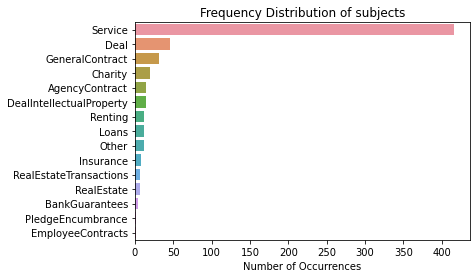


min 2
max 416
total 608


In [9]:
%matplotlib inline

subj_count = umtm.stats['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [10]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = umtm.stats['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(umtm.stats, 'subject')
class_weights

classes: ['Loans', 'GeneralContract', 'Service', 'BankGuarantees', 'Insurance', 'AgencyContract', 'RealEstateTransactions', 'Renting', 'Charity', 'PledgeEncumbrance', 'Deal', 'RealEstate', 'DealIntellectualProperty', 'Other', 'EmployeeContracts']


Service                     0.362664
Deal                        0.568285
GeneralContract             0.625762
Charity                     0.718662
AgencyContract              0.789148
DealIntellectualProperty    0.789148
Renting                     0.853031
Loans                       0.853031
Other                       0.853031
Insurance                   0.995794
RealEstateTransactions      1.124400
RealEstate                  1.124400
BankGuarantees              1.359470
PledgeEncumbrance           1.991587
EmployeeContracts           1.991587
Name: subject, dtype: float64

2020-06-28 23:13:02,586 - retrain_contract_uber_model - INFO - TOTAL DATAPOINTS IN TRAINSET: 609
2020-06-28 23:13:02,586 - retrain_contract_uber_model - INFO - TOTAL DATAPOINTS IN TRAINSET: 609
I0628 23:13:02.586119 4570262976 retrain_contract_uber_model.py:262] TOTAL DATAPOINTS IN TRAINSET: 609
2020-06-28 23:13:02,725 - retrain_contract_uber_model - INFO - docs in meta: 609
2020-06-28 23:13:02,725 - retrain_contract_uber_model - INFO - docs in meta: 609
I0628 23:13:02.725980 4570262976 retrain_contract_uber_model.py:289] docs in meta: 609
2020-06-28 23:13:02,734 - retrain_contract_uber_model - INFO - docs in meta after drop_duplicates: 609
2020-06-28 23:13:02,734 - retrain_contract_uber_model - INFO - docs in meta after drop_duplicates: 609
I0628 23:13:02.734735 4570262976 retrain_contract_uber_model.py:292] docs in meta after drop_duplicates: 609


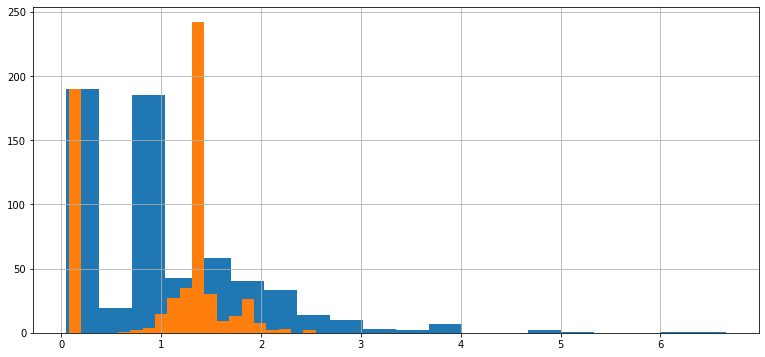

In [11]:
from trainsets.trainset_tools import get_feature_log_weights

def calculate_samples_weights(self):
  # TODO: sync with github!
  self.stats: DataFrame = self.load_contract_trainset_meta()
  subject_weights = get_feature_log_weights(self.stats, 'subject')
  
  value_median = self.stats.value_log1p.median()

  for i, row in self.stats.iterrows():
    subj_name = row['subject']

    tagging_weight = 1.0
    if not pd.isna(row['user_correction_date']):  # MORE weight for user-corrected datapoints
      tagging_weight = 10.0  # TODO: must be estimated anyhow smartly

    value_weight = value_median
    if not pd.isna(row['value_log1p']):
      # вес пропорционален логорифму цены контракта,
      # чтобы было меньше ошибок в контрактах на большие суммы)
      value_weight = row['value_log1p']

    tagging_weight *= value_weight
    subject_weight = tagging_weight * class_weights[subj_name]
    self.stats.at[i, 'subject_weight'] = subject_weight
    self.stats.at[i, 'sample_weight']  = tagging_weight

  # normalize weights, so the sum == Number of samples
  self.stats.sample_weight /= self.stats.sample_weight.mean()
  self.stats.subject_weight /= self.stats.subject_weight.mean()

  self._save_stats()

calculate_samples_weights(umtm)

plt.figure(figsize=(13, 6))

umtm.stats['subject_weight'].hist(bins=20)
umtm.stats['sample_weight'].hist(bins=20)

plt.xscale('linear') # log?
plt.show()

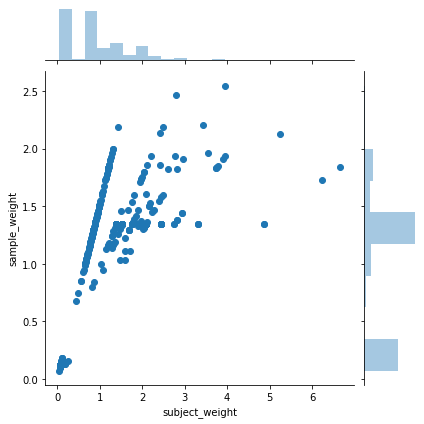

In [12]:
sns.jointplot(x="subject_weight", y="sample_weight", data=umtm.stats )
plt.show()


### look into trainset

In [13]:
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = umtm.stats.index[0]
print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
dp = umtm.make_xyw(SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
 

SAMPLE_DOC_ID 5eea279dc28b75807f3dacce


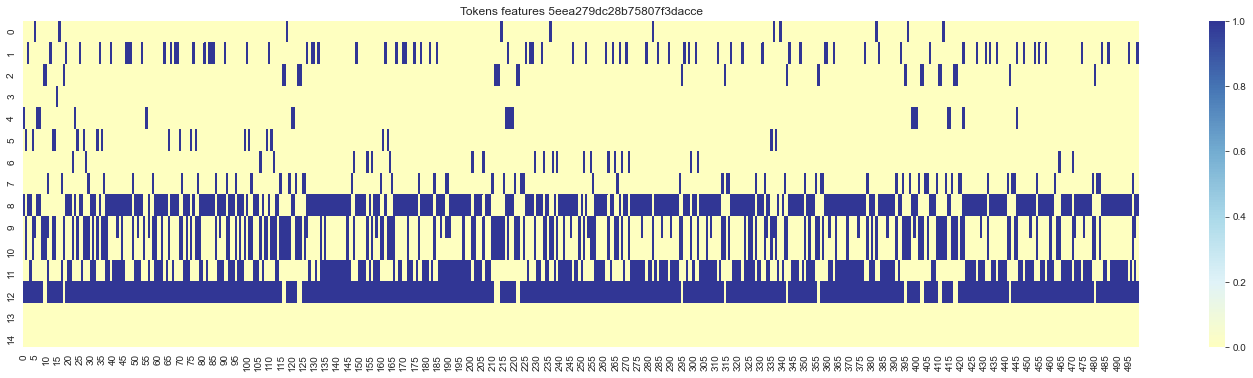

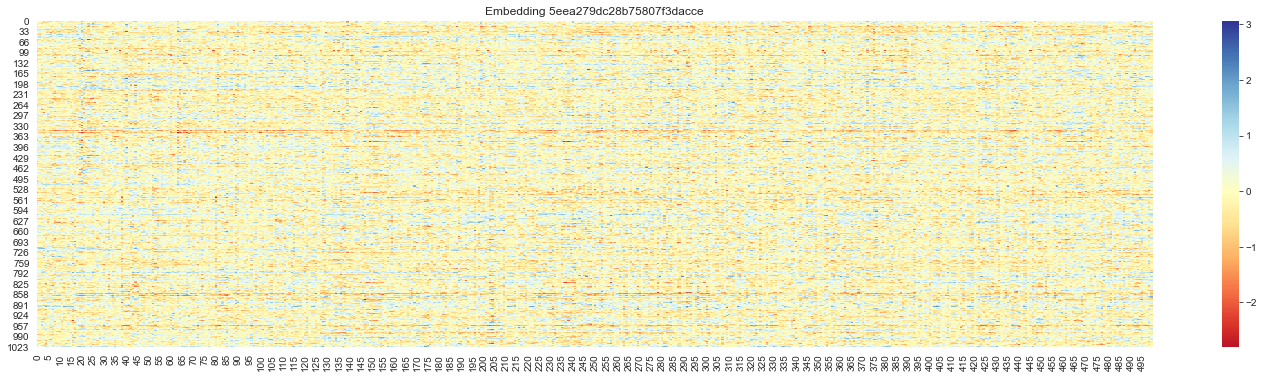

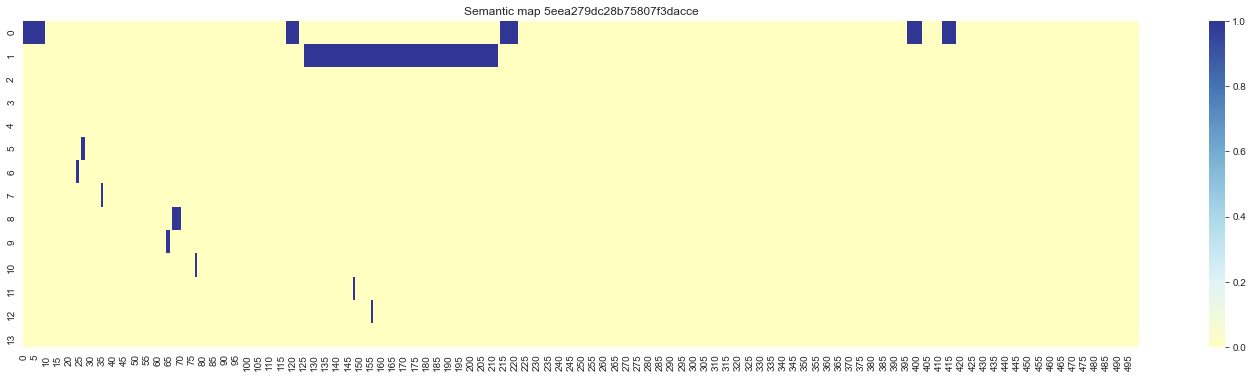

In [14]:
%matplotlib inline

plot_embedding(tok_f[:500], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:500], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:500], title=f'Semantic map {SAMPLE_DOC_ID}')

## Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq

In [15]:
def make_generator(self, indices: [int], batch_size: int, augment_samples=False):

  np.random.seed(42)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len =  random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = self.make_xyw(doc_id)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

      subject_weight_K=1.0
      if augment_samples:
        start_from = 0
        
        row = self.stats.loc[doc_id]
        if random.randint(1, 2) == 1:  # 50% of samples
          segment_center = random.randint(0, len(emb)-1) ##select random token as a center
          if not pd.isna(row['value_span']) and random.random()<0.7:        
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1 #lower subject weight because there mighе be no information about subject around doc. value

      dp = self.trim_maxlen(dp, start_from, max_len)
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Return a tuple of (input, output, weights) to feed the network
    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
            [np.array(batch_output_sm), np.array(batch_output_subj)],
            [np.array(weights), np.array(weights_subj)])

train_indices[0]: 5edbc59eda3678279fbcacae
test_indices[0]: 5edbc667da3678279fbcaf52
X: 2 X[0]= (24, 445, 1024) X[1]= (24, 445, 15)
Y: 2 Y[0]= (24, 445, 14) Y[1]= (24, 43)


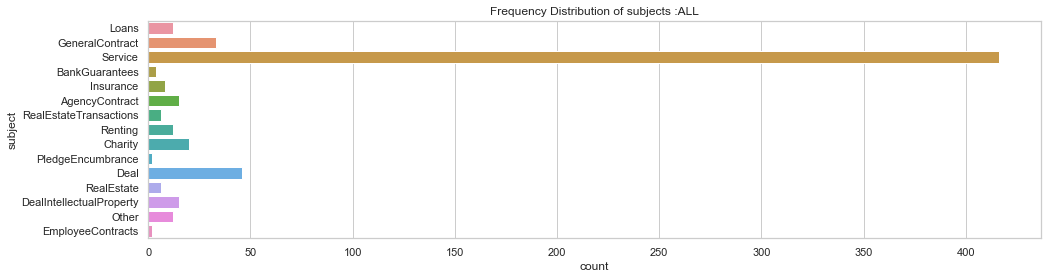

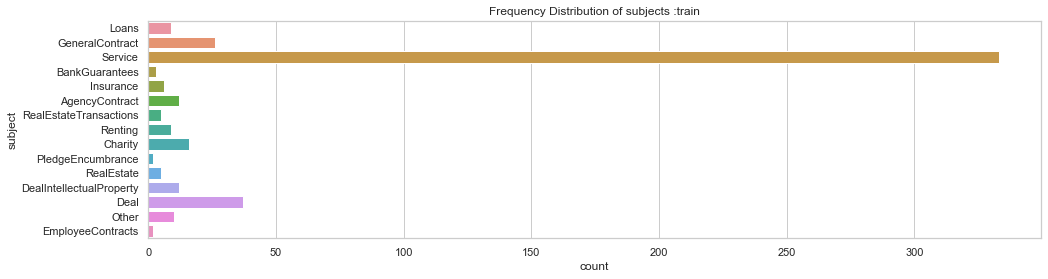

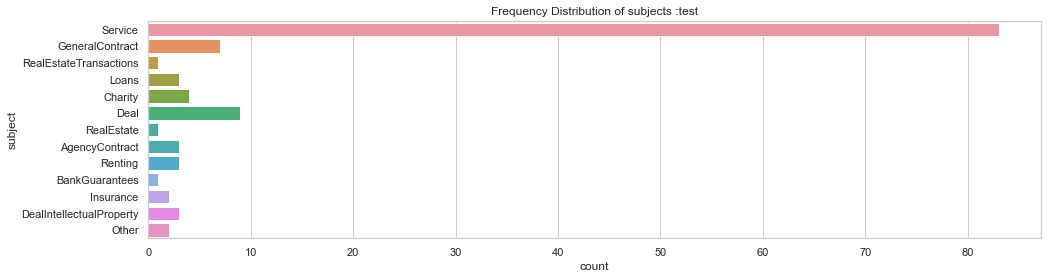

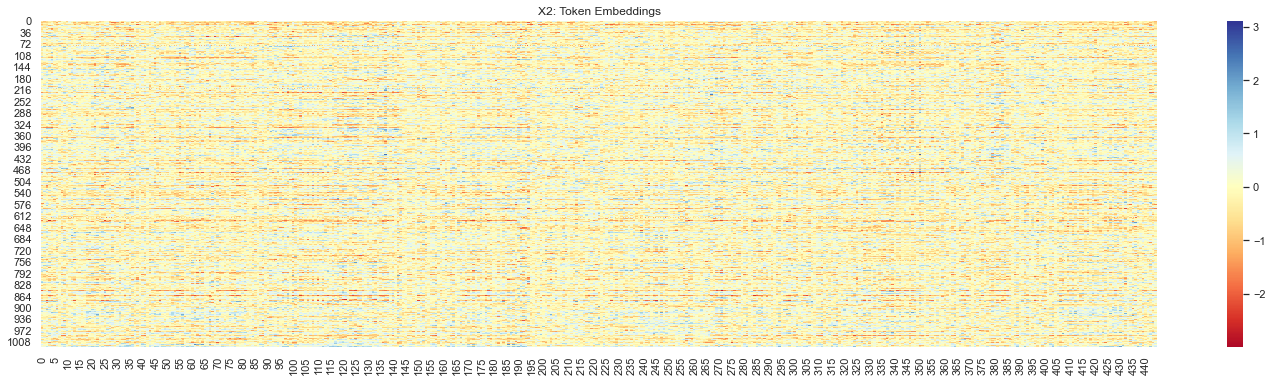

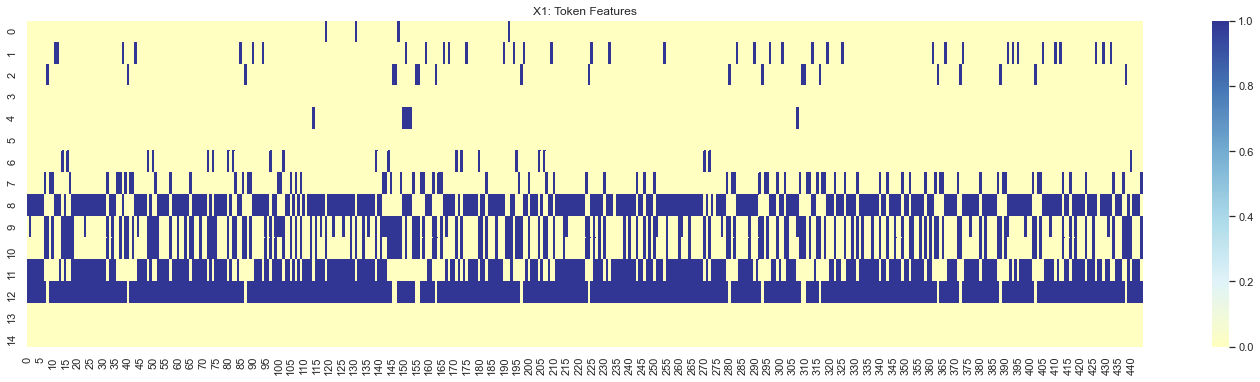

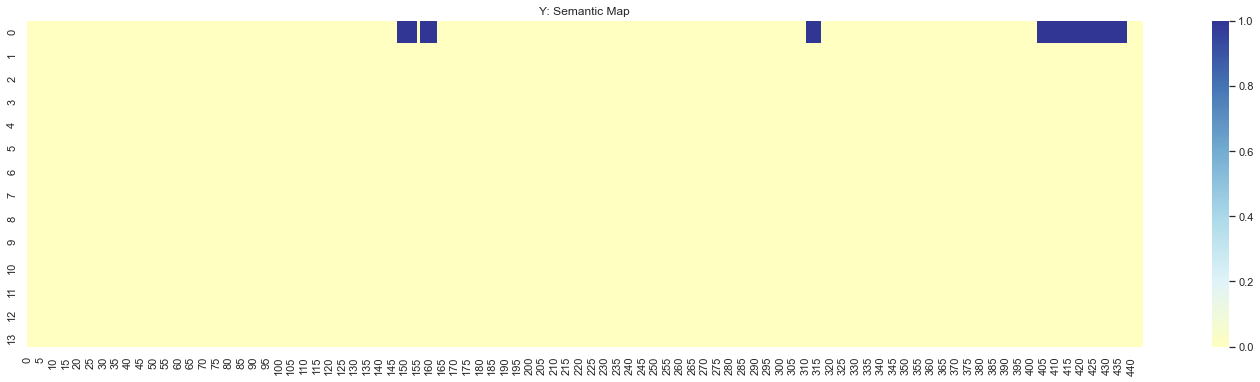

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
EPOCHS = 50
BATCH_SIZE = 24
EMB =  1024
 
_SELFTEST = True


_train, _test = train_test_split(umtm.stats, test_size=0.2, stratify=umtm.stats[['subject']])
train_indices = list(_train.index)
test_indices = list(_test.index)


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(umtm.stats, 'ALL')
plot_subject_distr(umtm.stats[umtm.stats.index.isin(train_indices)], 'train')
plot_subject_distr(umtm.stats[umtm.stats.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
  print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
  print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

  plot_embedding(x[0][0], 'X2: Token Embeddings')
  plot_embedding(x[1][0], 'X1: Token Features')
  plot_embedding(y[0][0], 'Y: Semantic Map')
  
  print(y[0][1])

  del x
  del w
  del y
  del train_gen

In [17]:

ctx = KerasTrainingContext(umtm.work_dir, session_index=21)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


batch_size:	24
train_samples:	1948
test_samples:	122
steps_per_epoch:	81
validation_steps:	40


In [18]:



def init_model(model_fn) -> (Model, KerasTrainingContext):
  model_name = model_fn.__name__
  model = model_fn(name=model_name, ctx=ctx, trained=True)
  model.name = model_name

  weights_file_old = os.path.join(models_path, model_name + ".weights")
  weights_file_new = os.path.join(umtm.work_dir, model_name + ".weights")

  try:
    model.load_weights(weights_file_new, by_name=True )
    logger.info(f'weights loaded: {weights_file_new}')

  except:
    msg = f'cannot load  {model_name} from  {weights_file_new}'
    warnings.warn(msg)
    logger.warning(msg)
    model.load_weights(weights_file_old, by_name=True )
    logger.info(f'weights loaded: {weights_file_old}')

  # freeze bottom 6 layers, including 'embedding_reduced' #TODO: this must be model-specific parameter
  for l in model.layers[0:6]:
    l.trainable = False

  model.compile(loss=super_contract_model.losses, optimizer='Nadam', metrics=super_contract_model.metrics)
  model.summary()

  return model




# Models 🦖

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [19]:


umodel = init_model(uber_detection_model_005_1_1)

######################
# Phase I retraining
# ❄️ frozen bottom layers
######################
test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

ctx.EPOCHS = 25
ctx.EVALUATE_ONLY = False
ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

W0628 23:13:25.531170 4570262976 deprecation.py:506] From /Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0628 23:13:26.338331 4570262976 module_wrapper.py:139] From /Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

2020-06-28 23:13:28,463 - retrain_contract_uber_model - INFO - weights loaded: /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights
2020-06-28 23:13:28,463 - retrain_contract_uber_model - INFO - weights loaded: /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights
I0628 23:13:28.463253 4

Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     (None, None, 1024)   0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer (None, None, 15)     0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 1039)   0           drops[0][0]                      
                                                                 input_

W0628 23:13:29.380422 4570262976 deprecation.py:323] From /Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


continue: lr:0.0020000000949949026, epoch:0


W0628 23:13:31.792809 4570262976 module_wrapper.py:139] From /Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/25
81/81 [==============================] - 163s 2s/step - loss: 0.0136 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0074 - O1_tagging_kullback_leibler_divergence: 0.0466 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.4974 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0185 - val_loss: 0.0101 - val_O1_tagging_loss: 0.0040 - val_O2_subject_loss: 0.0037 - val_O1_tagging_kullback_leibler_divergence: 0.0337 - val_O1_tagging_mse: 9.7052e-04 - val_O1_tagging_binary_crossentropy: 0.0050 - val_O2_subject_kullback_leibler_divergence: 0.0573 - val_O2_subject_mse: 4.8826e-04 - val_O2_subject_binary_crossentropy: 0.0025

Epoch 00001: val_loss improved from inf to 0.01013, saving model to /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights
Epoch 2/25
81/81 [==============================] - 161s 2s/step - loss: 0.0136 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0077 - O1_tagging_kullback_leib

81/81 [==============================] - 162s 2s/step - loss: 0.0134 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0078 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_kullback_leibler_divergence: 0.4579 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0173 - val_loss: 0.0111 - val_O1_tagging_loss: 0.0043 - val_O2_subject_loss: 0.0047 - val_O1_tagging_kullback_leibler_divergence: 0.0337 - val_O1_tagging_mse: 0.0010 - val_O1_tagging_binary_crossentropy: 0.0052 - val_O2_subject_kullback_leibler_divergence: 0.0691 - val_O2_subject_mse: 6.7752e-04 - val_O2_subject_binary_crossentropy: 0.0030

Epoch 00011: val_loss did not improve from 0.00304
Epoch 12/25
81/81 [==============================] - 168s 2s/step - loss: 0.0152 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0094 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject


Epoch 00021: val_loss did not improve from 0.00304
Epoch 22/25
81/81 [==============================] - 176s 2s/step - loss: 0.0123 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0065 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_kullback_leibler_divergence: 0.4582 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0172 - val_loss: 0.0081 - val_O1_tagging_loss: 0.0040 - val_O2_subject_loss: 0.0050 - val_O1_tagging_kullback_leibler_divergence: 0.0299 - val_O1_tagging_mse: 9.8559e-04 - val_O1_tagging_binary_crossentropy: 0.0053 - val_O2_subject_kullback_leibler_divergence: 0.0722 - val_O2_subject_mse: 7.0060e-04 - val_O2_subject_binary_crossentropy: 0.0031

Epoch 00022: val_loss did not improve from 0.00304
Epoch 23/25
81/81 [==============================] - 170s 2s/step - loss: 0.0118 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0066 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_taggi

In [20]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
ctx.unfreezeModel(umodel)
umodel.compile(loss=super_contract_model.losses, optimizer='Nadam', metrics=super_contract_model.metrics)
umodel.summary()

ctx.EPOCHS *= 2

test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
 
ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     (None, None, 1024)   0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer (None, None, 15)     0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 1039)   0           drops[0][0]                      
                                                                 input_


Epoch 00031: val_loss did not improve from 0.00354
Epoch 32/50
81/81 [==============================] - 168s 2s/step - loss: 0.0128 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0069 - O1_tagging_kullback_leibler_divergence: 0.0416 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_kullback_leibler_divergence: 0.4066 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0156 - val_loss: 0.0090 - val_O1_tagging_loss: 0.0047 - val_O2_subject_loss: 0.0085 - val_O1_tagging_kullback_leibler_divergence: 0.0271 - val_O1_tagging_mse: 8.3665e-04 - val_O1_tagging_binary_crossentropy: 0.0051 - val_O2_subject_kullback_leibler_divergence: 0.1555 - val_O2_subject_mse: 0.0015 - val_O2_subject_binary_crossentropy: 0.0060

Epoch 00032: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 00032: val_loss did not improve from 0.00354
Epoch 33/50
81/81 [==============================] - 506s 6s/step - loss: 0.0116 - O1_tagging_loss: 0.0050 - O2_sub


Epoch 00042: val_loss did not improve from 0.00354
Epoch 43/50
81/81 [==============================] - 205s 3s/step - loss: 0.0126 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0070 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_kullback_leibler_divergence: 0.4624 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0172 - val_loss: 0.0128 - val_O1_tagging_loss: 0.0048 - val_O2_subject_loss: 0.0066 - val_O1_tagging_kullback_leibler_divergence: 0.0285 - val_O1_tagging_mse: 9.2330e-04 - val_O1_tagging_binary_crossentropy: 0.0052 - val_O2_subject_kullback_leibler_divergence: 0.1436 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0053

Epoch 00043: val_loss did not improve from 0.00354
Epoch 44/50
81/81 [==============================] - 198s 2s/step - loss: 0.0120 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0064 - O1_tagging_kullback_leibler_divergence: 0.0414 - O1_tagging_m

# Evaluate models

In [21]:
# umodel = ctx.init_model(uber_detection_model_005_1_1, weights_file_override='/content/uber_detection_model_005_1_1', trained=True)

### training history

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


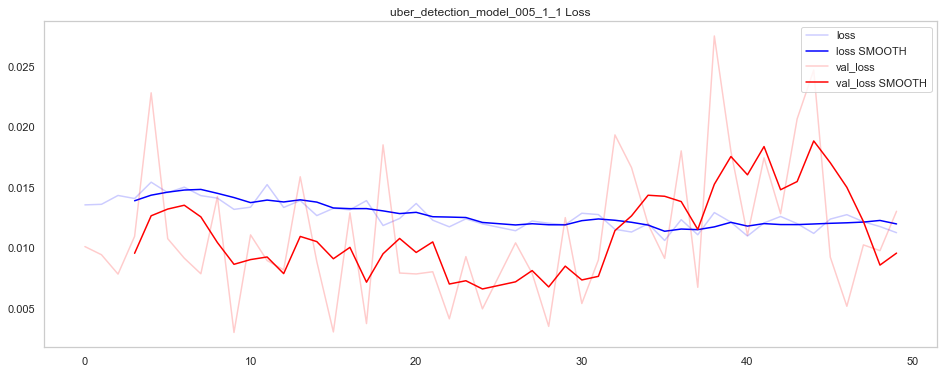

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


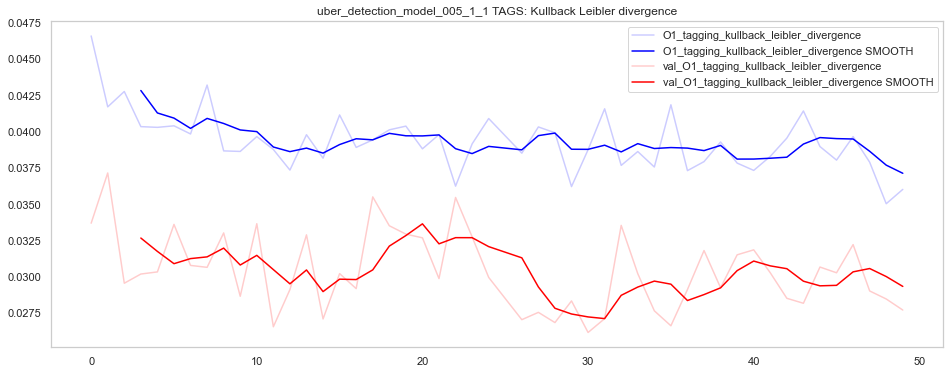

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


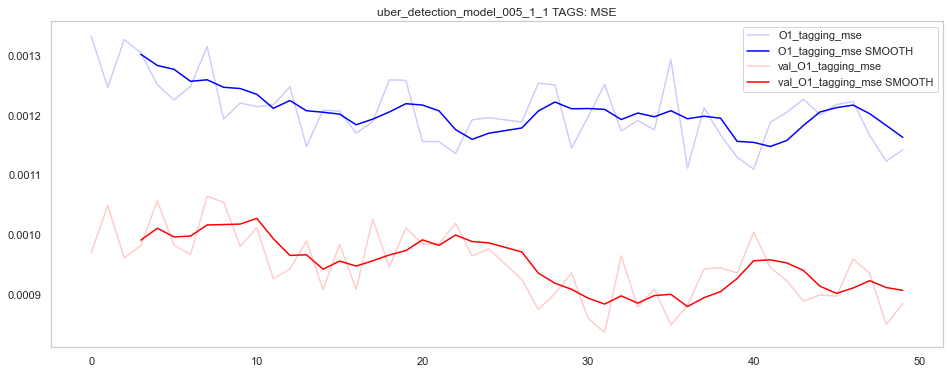

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


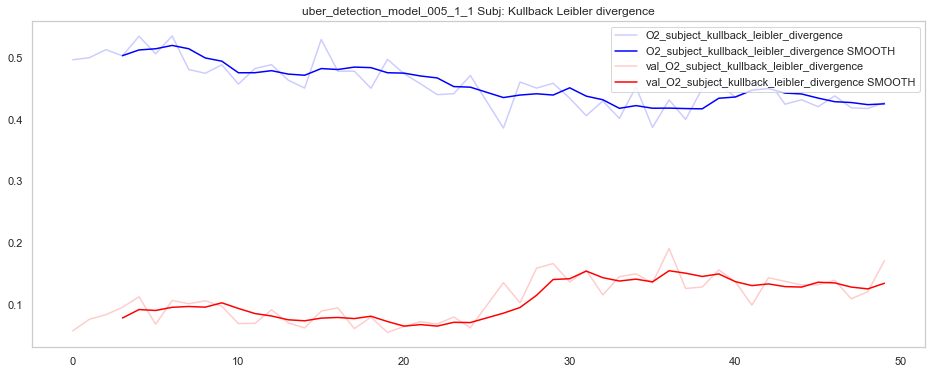

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


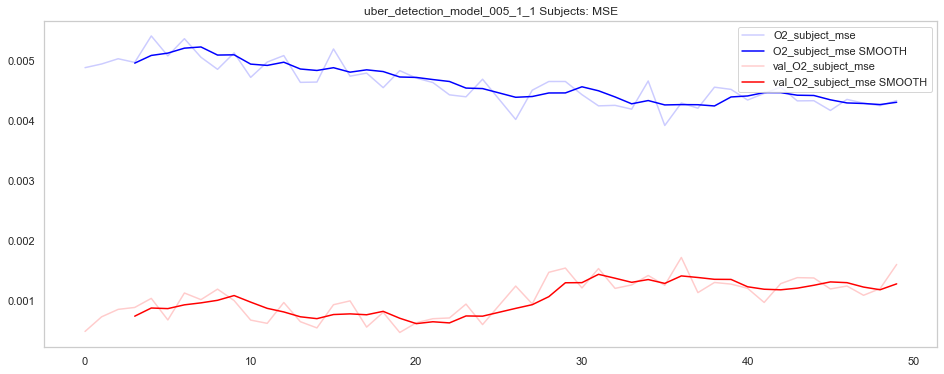

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


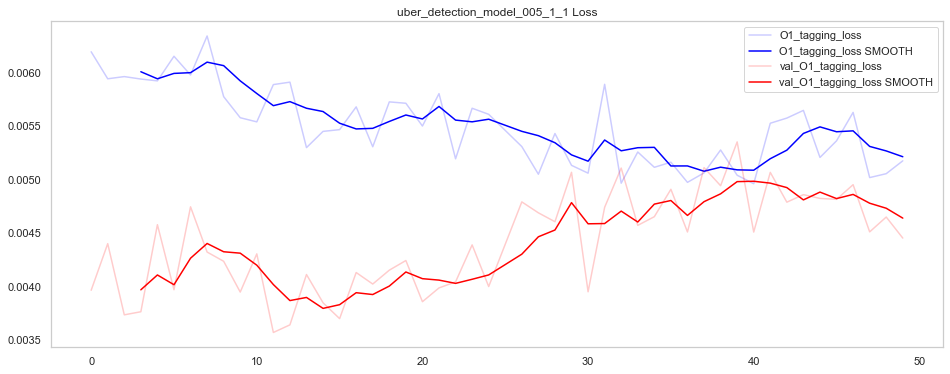

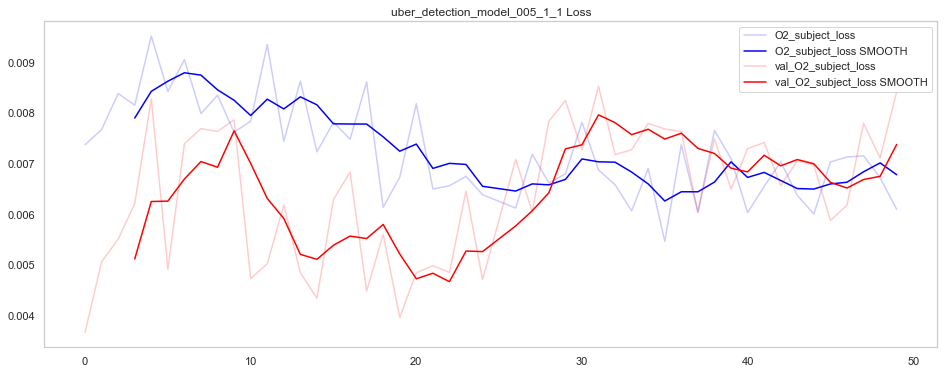

In [22]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.work_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid()
        plt.title(f'{metric}')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{m} {title}')
        plt.grid()
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        plt.savefig(img_path, bbox_inches='tight')
        plt.grid()
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')

## Contract subj Confusion matrices

In [27]:
def plot_cm(y_true, y_pred, figsize=(12, 12), title=None):
  cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
  cm_sum = np.sum(cm, axis=1, keepdims=True)
  cm_perc = cm / cm_sum.astype(float) * 100
  annot = np.empty_like(cm).astype(str)
  nrows, ncols = cm.shape
  for i in range(nrows):
    for j in range(ncols):
      c = cm[i, j]
      p = cm_perc[i, j]
      if i == j:
        s = cm_sum[i]
        annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
      elif c == 0:
        annot[i, j] = ''
      else:
        annot[i, j] = '%.1f%%\n%d' % (p, c)

  cm = pd.DataFrame(cm_perc, index=np.unique(y_true), columns=np.unique(y_true))
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  fig, ax = plt.subplots(figsize=figsize)
  sns.heatmap(cm, cmap="YlGnBu", annot=annot, fmt='', ax=ax)
  plt.title(title)


def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for _id in indices:

    x, y, _ = umtm.make_xyw(_id)
    embeddings = x[0]
    token_features = x[1]
    prediction = umodel.predict(x=[np.expand_dims(embeddings, axis=0), np.expand_dims(token_features, axis=0)],
                                batch_size=1)

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj']=expected.name
    ev.at[_id, 'predicted_subj']=predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True       

  return ev



subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
ev = make_subj_predictions(umodel, subset.index)

In [28]:
errors_report = ev [ ev.wrong == True].sort_values('expected_subj')
print(len(errors_report), 'wrong subjects of', len(subset))
errors_report

25 wrong subjects of 419


,export_date,subject,org-1-alias,org-2-alias,checksum,version,analyze_date,value,value_log1p,value_span,subject confidence,user_correction_date,valid,subject_weight,sample_weight,error,expected_subj,predicted_subj,wrong
_id,,,,,,,,,,,,,,,,,,,
5edbc66ada3678279fbcafb5,2020-06-26 21:18:47.480707,AgencyContract,Принципал,Агент,56488a6f7009adcf52eee81715c1c06b,1.11.5,2020-06-16 11:35:38.263,1.538734e+08,18.851641,361.0,0.000000,2020-06-15 11:31:23.277,True,2.775085,1.934006,NaN,AgencyContract,GeneralContract,True
5eea27b4c28b75807f3daf4f,2020-06-26 21:20:15.771200,AgencyContract,Принципал,Агент,938a52fa4ad6e7a1ab7ff196058eeadd,1.20.0,2020-06-19 18:51:55.532,5.404309e+07,17.805292,1185.0,0.269345,2020-06-19 10:50:00.319,True,2.621056,1.826660,NaN,AgencyContract,GeneralContract,True
5e587dce99b345c81a70340d,2020-06-26 21:19:12.511327,BankGuarantees,ПРИНЦИПАЛ,ГАРАНТ,2f8e4fea485098a923890f040b8e72b9,1.12.0,2020-06-16 18:33:25.117,9.900000e+08,20.713216,724.0,0.000000,2020-06-16 10:13:43.116,True,5.252740,2.124986,NaN,BankGuarantees,Insurance,True
5eea27b0c28b75807f3daeae,2020-06-26 21:20:13.501527,BankGuarantees,ГАРАНТ,ПРИНЦИПАЛ,5e8766b3b972a5dca6a611994bbb48c8,1.20.0,2020-06-19 18:45:33.329,NaN,NaN,NaN,0.000000,2020-06-19 10:22:27.899,True,3.327492,1.346131,NaN,BankGuarantees,Loans,True
5eea27b0c28b75807f3daead,2020-06-26 21:20:13.111230,BankGuarantees,ГАРАНТ,ПРИНЦИПАЛ,926e682568c6a961e1f85cd21fb6ec99,1.20.0,2020-06-19 18:45:21.307,NaN,NaN,NaN,0.000000,2020-06-19 10:26:09.328,True,3.327492,1.346131,NaN,BankGuarantees,Loans,True
5edbadd0da3678279fbcaa4d,2020-06-26 21:18:00.289893,Deal,Продавец,Покупатель,fe4b5d5492c02df86582971284c5ccac,1.11.2,2020-06-12 21:29:09.200,8.403750e+04,11.339030,729.0,0.750807,2020-06-06 15:56:22.897,True,1.202018,1.163281,NaN,Deal,RealEstateTransactions,True
5dece9bf4ddc27bcf92dd419,2020-06-26 21:19:33.066100,DealIntellectualProperty,Сублицензиат,Лицензиат,699bcfc1478e06e31aa46be694bd059c,1.12.0,2020-06-16 19:19:00.045,NaN,NaN,NaN,0.314508,2020-06-16 11:16:37.708,True,1.931549,1.346131,NaN,DealIntellectualProperty,AgencyContract,True
5edbc630da3678279fbcadfa,2020-06-26 21:18:23.563600,DealIntellectualProperty,Конечный пользователь,Сублицензиат,9961f7e27f74de66ccc363e811479fbe,1.11.5,2020-06-16 11:10:48.506,NaN,NaN,NaN,0.981551,2020-06-10 14:25:13.525,True,1.931549,1.346131,NaN,DealIntellectualProperty,AgencyContract,True
5edbc659da3678279fbcae37,2020-06-26 21:18:25.842385,DealIntellectualProperty,Конечный пользователь,Сублицензиат,ffafa44ed6623eb8d32900acc87e51cf,1.11.5,2020-06-16 11:14:00.670,5.000000e+04,10.819798,2782.0,0.969697,2020-06-12 05:35:31.662,True,1.592745,1.110012,NaN,DealIntellectualProperty,AgencyContract,True


uber_detection_model_005_1_1
                          precision    recall  f1-score   support

          AgencyContract      0.571     0.857     0.686        14
          BankGuarantees      1.000     0.250     0.400         4
                 Charity      1.000     1.000     1.000        17
                    Deal      0.936     0.978     0.957        45
DealIntellectualProperty      1.000     0.600     0.750        15
       EmployeeContracts      0.000     0.000     0.000         2
         GeneralContract      0.857     0.909     0.882        33
               Insurance      0.889     1.000     0.941         8
                   Loans      0.786     1.000     0.880        11
                   Other      1.000     0.917     0.957        12
       PledgeEncumbrance      1.000     1.000     1.000         2
              RealEstate      0.800     0.667     0.727         6
  RealEstateTransactions      0.857     1.000     0.923         6
                 Renting      0.923     1.000 

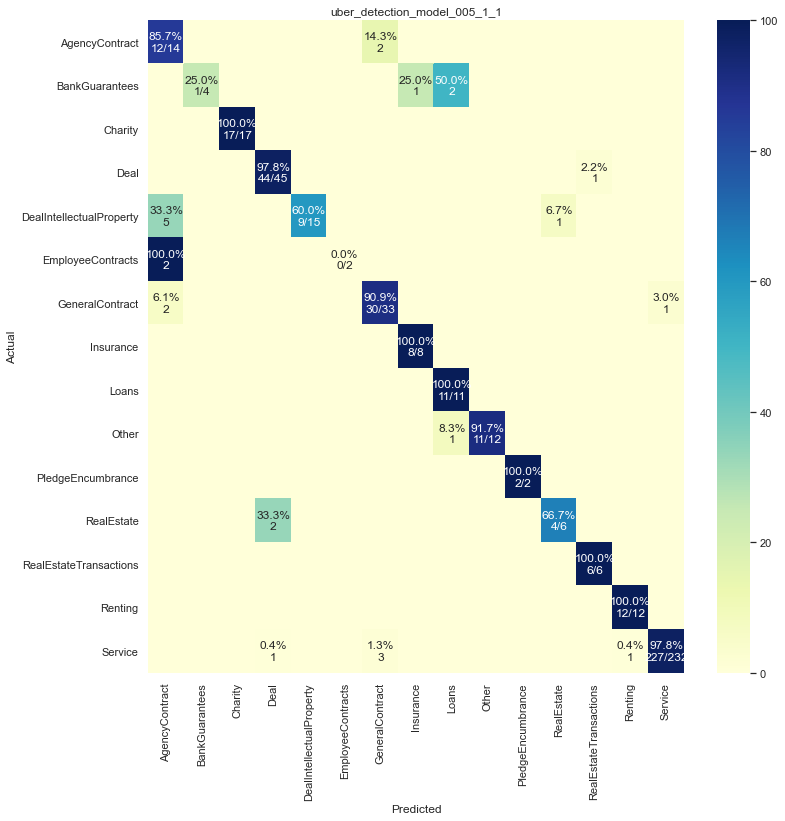

In [30]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'], title=umodel.name)
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


make_report(umodel, ev[~pd.isna(ev['predicted_subj'])])

## Single doc eval

In [ ]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  SAMPLE_DOC_ID = umtm.stats.index[10]
  print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp


  print(f'fetching {SAMPLE_DOC_ID}')
  db = get_mongodb_connection()
  documents_collection = db['documents']
  jdata =  documents_collection.find_one({'_id': ObjectId(SAMPLE_DOC_ID)})
  jdoc = DbJsonDoc(jdata)


In [ ]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

In [ ]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
tagging = prediction[0][0]

subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


df = pd.DataFrame(tagging, columns=seq_labels_contract)

plot_embedding(df, title = f'Predictions of {umodel.name}')



In [ ]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( df[t].values, threshold=0.3))  
  print(t.upper(), spans)
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, df[t].values)))


In [ ]:
mean_ = df.values.max(-1)*0.5
print (mean_.shape)
display(HTML( to_color_text (jdoc.get_tokens_map_unchaged().tokens[:14000],  mean_[:14000])))